<a href="https://colab.research.google.com/github/RexGod/DataMining_Pgu_Nueral_Network/blob/main/finalDeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2

In [ ]:
pathImages = '/content/drive/MyDrive/tits_pic'

In [ ]:
pathManual = '/content/drive/MyDrive/Radiology_manual_annotations.xlsx'
manualRadio = pd.read_excel(pathManual)

In [ ]:
manualRadio= manualRadio.rename(columns={'Pathology Classification/ Follow up':'classification'})

In [ ]:
manualRadio = manualRadio[manualRadio['Type']=='CESM']

In [ ]:
import os
images = os.listdir(pathImages)
loaded_images = []
#filename_txt = []
for filename in images:
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image_list = os.path.join(pathImages, filename)
        loaded_images.append(image_list)
        #filename_txt.append(filename)

In [ ]:
loaded_images = sorted(loaded_images, key=lambda x: x.lower())

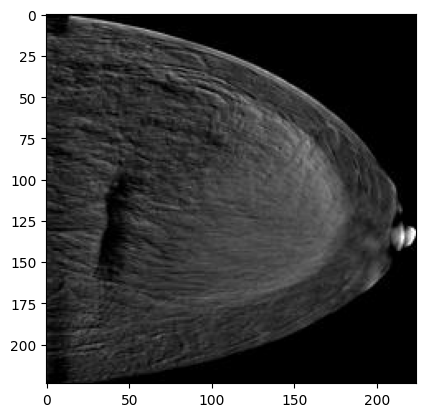

In [ ]:
img1 = plt.imread(loaded_images[0])
plt.imshow(img1)

In [ ]:
loaded_image = []
for image_path in loaded_images:
    image = plt.imread(image_path)
    loaded_image.append(image)

In [ ]:
manualRadio = manualRadio.sort_values(by=['Image_name'])

In [ ]:
manualRadio.head()

,Image_name,Patient_ID,Side,Type,Age,Breast density (ACR),BIRADS,Findings,View,Tags,Machine,classification
556,P100_L_CM_CC,100,L,CESM,61,_,2,Non enhancement,CC,postoperative,1,Benign
557,P100_L_CM_MLO,100,L,CESM,61,_,2,Non enhancement,MLO,postoperative,1,Benign
552,P100_R_CM_CC,100,R,CESM,61,_,1,No mass or non mass enhancement,CC,normal,1,Normal
553,P100_R_CM_MLO,100,R,CESM,61,_,1,No mass or non mass enhancement,MLO,normal,1,Normal
564,P101_L_CM_CC,101,L,CESM,47,_,1,No mass or non mass enhancement,CC,normal,1,Normal


In [ ]:
validation_data_size = int(len(loaded_image)*0.12)
test_data_size = int(len(loaded_image)*0.13)

In [ ]:
random_select = np.random.choice(len(loaded_image), size=validation_data_size, replace=False)

In [ ]:
print(random_select)

[924 855 350 991 216 895 357   0 390 987 195 112 330 880 518 767 770 979
 516 878 938 403 921 627 400 786 525 853 159 526 446 811 919 742 515 224
 481 837 480  95 815 563 777 379 699 568 183 449 302 346 151 612 776 953
 817 427 812 254 575   7 243  58 437 747 259 829 434 297 450 727 601 167
 558 787 165 752 630 310 162  35 472 204  91 360 990 743 530 490 280 367
 180 769 409 134 358 806 283 329 286  59 782 980 342 995 619 850 993  41
 928 116 764 253  22 549 808 670 657  84 538 206]


In [ ]:
validation_data_x = np.array(loaded_image)[random_select]
validation_data_y = manualRadio.iloc[random_select]
loaded_image = np.delete(loaded_image, random_select, axis=0)
manualRadio=manualRadio.drop(manualRadio.index[random_select])

In [ ]:
random_select = np.random.choice(len(loaded_image), size=test_data_size, replace=False)

In [ ]:
test_data_x = np.array(loaded_image)[random_select]
test_data_y = manualRadio.iloc[random_select]
loaded_image = np.delete(loaded_image, random_select, axis=0)
manualRadio=manualRadio.drop(manualRadio.index[random_select])

In [ ]:
train_data_x = np.array(loaded_image)
train_data_y = manualRadio[["Image_name" , "classification"]]

In [ ]:
import tensorflow as tf
import keras

In [ ]:
manualRadio.head()

,Image_name,Patient_ID,Side,Type,Age,Breast density (ACR),BIRADS,Findings,View,Tags,Machine,classification
557,P100_L_CM_MLO,100,L,CESM,61,_,2,Non enhancement,MLO,postoperative,1,Benign
552,P100_R_CM_CC,100,R,CESM,61,_,1,No mass or non mass enhancement,CC,normal,1,Normal
553,P100_R_CM_MLO,100,R,CESM,61,_,1,No mass or non mass enhancement,MLO,normal,1,Normal
564,P101_L_CM_CC,101,L,CESM,47,_,1,No mass or non mass enhancement,CC,normal,1,Normal
565,P101_L_CM_MLO,101,L,CESM,47,_,1,No mass or non mass enhancement,MLO,normal,1,Normal


In [ ]:
label_mapping = {'Benign': 0, 'Normal': 1, 'Malignant': 2}

In [ ]:
integer_labels = train_data_y['classification'].map(label_mapping)
integer_labels_valid = validation_data_y['classification'].map(label_mapping)
y_train_to_categorical = keras.utils.to_categorical(integer_labels, num_classes=len(label_mapping), dtype='float32')
y_validation_to_categorical = keras.utils.to_categorical(integer_labels_valid, num_classes=len(label_mapping), dtype='float32')

In [ ]:
from tensorflow.keras.applications.resnet import ResNet101,ResNet152 , preprocess_input , decode_predictions

In [ ]:
#train_images_rgb = np.repeat(train_data_x[..., np.newaxis], 3, -1)[..., 0]
#test_images_rgb = np.repeat(test_data_x[..., np.newaxis], 3, -1)
#validation_images_rgb = np.repeat(validation_data_x[..., np.newaxis], 3, -1)[..., 0]


In [ ]:
train_data_x = train_data_x/255
validation_data_x = validation_data_x/255

In [ ]:
base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

234698864/234698864 [==============================] - 10s 0us/step


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D , Conv2D , Flatten , Dropout , MaxPooling2D , BatchNormalization
from keras import layers
from tensorflow.keras.optimizers import Adam,Adamax,SGD


In [ ]:
model = Sequential()

In [ ]:
model.add(base_model)

In [ ]:
for layer in base_model.layers:
    layer.trainable = True

for layer in base_model.layers[:-7]:
    layer.trainable = False

In [ ]:
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,  # Rotate the image by a random angle between -20 and 20 degrees
    width_shift_range=0.1,  # Shift the image horizontally by a fraction of its width
    height_shift_range=0.1,  # Shift the image vertically by a fraction of its height
    shear_range=0.2,  # Apply shear transformation
    zoom_range=0.2,  # Apply zoom transformation
    horizontal_flip=True,  # Flip the image horizontally
    vertical_flip=False,  # Do not flip the image vertically
    fill_mode='nearest'  # Fill any empty pixels created during the augmentation process
)

In [ ]:
train_generator = datagen.flow(train_data_x, y_train_to_categorical, batch_size=32)

In [ ]:
model.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy' , 'AUC' ])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True ,)

In [ ]:
nemudar = model.fit(train_generator,
                    validation_data=(validation_data_x,y_validation_to_categorical ),
                    epochs=50,
                    callbacks = [early_stopping]
                    )


Epoch 1/50
24/24 [==============================] - 32s 730ms/step - loss: 1.4889 - accuracy: 0.3758 - auc: 0.5464 - val_loss: 1.2709 - val_accuracy: 0.3250 - val_auc: 0.4992
Epoch 2/50
24/24 [==============================] - 12s 499ms/step - loss: 1.3276 - accuracy: 0.4037 - auc: 0.5799 - val_loss: 1.2848 - val_accuracy: 0.3250 - val_auc: 0.5111
Epoch 3/50
24/24 [==============================] - 13s 520ms/step - loss: 1.3700 - accuracy: 0.4077 - auc: 0.5610 - val_loss: 1.1315 - val_accuracy: 0.3250 - val_auc: 0.5460
Epoch 4/50
24/24 [==============================] - 12s 477ms/step - loss: 1.2902 - accuracy: 0.4024 - auc: 0.5823 - val_loss: 1.0569 - val_accuracy: 0.5000 - val_auc: 0.6291
Epoch 5/50
24/24 [==============================] - 12s 495ms/step - loss: 1.2948 - accuracy: 0.3838 - auc: 0.5663 - val_loss: 1.0385 - val_accuracy: 0.5000 - val_auc: 0.6538
Epoch 6/50
24/24 [==============================] - 12s 502ms/step - loss: 1.2491 - accuracy: 0.4090 - auc: 0.5905 - val_loss

Text(0.5, 1.0, 'val_loss')

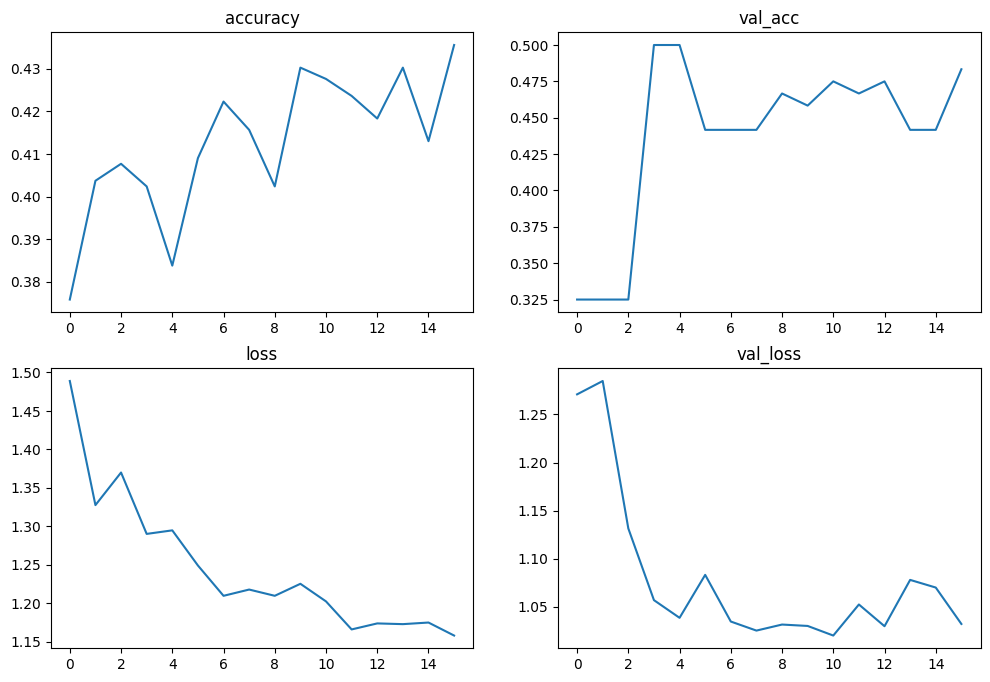

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(2,2,1)
plt.plot(nemudar.history['accuracy'])
plt.title('accuracy')
plt.subplot(2,2,2)
plt.plot(nemudar.history['val_accuracy'])
plt.title('val_acc')
plt.subplot(2,2,3)
plt.plot(nemudar.history['loss'])
plt.title('loss')
plt.subplot(2,2,4)
plt.plot(nemudar.history['val_loss'])
plt.title('val_loss')

In [ ]:
model.save('/content/drive/MyDrive/ResNet152new.h5')

In [ ]:
Resmodel = tf.keras.models.load_model('/content/drive/MyDrive/ResNet152new.h5')

In [ ]:
test_data_x = test_data_x/255

In [ ]:
integer_labels_test = test_data_y['classification'].map(label_mapping)
y_test_to_categorical = keras.utils.to_categorical(integer_labels_test, num_classes=len(label_mapping), dtype='float32')

In [ ]:
predictions = model.predict(test_data_x)

predicted_labels = np.argmax(predictions, axis=1)

5/5 [==============================] - 6s 223ms/step


In [ ]:
Resmodel.evaluate(test_data_x,y_test_to_categorical )

5/5 [==============================] - 4s 172ms/step - loss: 0.9709 - accuracy: 0.6077 - auc: 0.7753


[0.9709044098854065, 0.607692301273346, 0.7753402590751648]

In [ ]:
print(predicted_labels)

[1 1 2 1 1 1 1 1 2 1 1 2 1 1 1 1 1 1 2 1 1 1 1 1 1 2 2 1 2 1 1 1 1 1 1 1 1
 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 1
 1 1 2 1 2 1 1 1 1 1 1 1 1 1 1 2 2 2 2 1 1 1 1 1 1 2 1 1 1 1 1 1 2 1 2 1 1
 2 1 1 1 1 1 2 1 1 1 1 2 1 1 1 1 1 1 1]


In [ ]:
print(y_test_to_categorical)

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0.